In [1]:
import gym
import gym_anytrading
import os

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

2023-06-27 20:55:18.963678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 20:55:19.595919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def genreate_stock_data(stock_name,period):
    company = yf.Ticker(stock_name)
    df = company.history(period=period)
    
    #Sepreate the dates of the stock for further use if required
    date = (df.reset_index())['Date']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove data object from the database
    df = (df.reset_index()).drop('Date',axis=1)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the current trend of the current stock
    t = []
    for i in range(len(df)):
        if(df['Open'].iloc[i]-df['Close'].iloc[i]>0):
            t.append("DOWN")
        else:
            t.append("UP")
            
    df['Trend']=t
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the trend history of the stock
    th=[0]
    current_trend = df['Trend'].iloc[0]
    count = 0
    for i in range(1,len(df)):
        if(current_trend==df['Trend'].iloc[i]):
            count+=1
            th.append(count)
        else:
            count = 0
            th.append(count)
            current_trend = df['Trend'].iloc[i]
            
    df["Trend history"]=th
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the comparison to the change since last peak
    p=[]
    v=[]
    if(df['Trend'].iloc[0]=="DOWN"):
        peak = df['Open'].iloc[0]
        valley = df['Close'].iloc[0]
    else:
        valley = df['Open'].iloc[0]
        peak = df['Close'].iloc[0]

    for i in range(0,len(df)):

        p.append(peak-df['Close'].iloc[i])
        v.append(valley-df['Close'].iloc[i])

        if peak<df['Close'].iloc[i]:
            peak = df['Close'].iloc[i]
        if valley>df['Close'].iloc[i]:
            valley = df['Close'].iloc[i]
            
    df['Change since last peak']=p
    df['Change since last drop']=v
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the local change of daily stock
    c=[]
    cm=[]
    for i in range(0,len(df)):
        c.append(df['Open'].iloc[i]-df['Close'].iloc[i])
        cm.append(df['High'].iloc[i]-df['Low'].iloc[i])

    df['Local Change']=c
    df['Local range of stock price']=cm
    #-------------------------------------------------------------------------------------------------------------
    
    #Create dummy variable for the categorical variable
    df = pd.get_dummies(df,drop_first=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the label for the change from tommorow, the data that needs to be predicted
    next_day_change = df[1:]
    next_day_change = next_day_change['Local Change']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove The last column as the it is redundant
    df.drop(index=df.index[-1],axis=0,inplace=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Break the data into features and labels
    X = df
    y = next_day_change
    #-------------------------------------------------------------------------------------------------------------
    
    return(date,X,y)

In [8]:
def bot_work(stock):
    date,X,y = genreate_stock_data(stock,'max')
    X['Date']=date
    X.set_index(['Date'],inplace=True)
    env_maker = lambda: gym.make('stocks-v0', df=X, frame_bound=(5,100), window_size=5)
    env = DummyVecEnv([env_maker])
    model = A2C('MlpPolicy', env, verbose=1) 
    model.learn(total_timesteps=100)
    env = gym.make('stocks-v0', df=X,frame_bound = (900,1000),window_size=5)
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
    
    path = path = 'models/'+stock+'/trading_bot/'
    
    if not os.path.isdir(path):
        os.makedirs(path)
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()
    plt.savefig(path+'bot_evaluation.png')

/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 2)
  logger.warn(
/home/om/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/om/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/om/.local/l

Using cpu device
info {'total_reward': 0.08862510323524475, 'total_profit': 0.9255623600023093, 'position': 1}


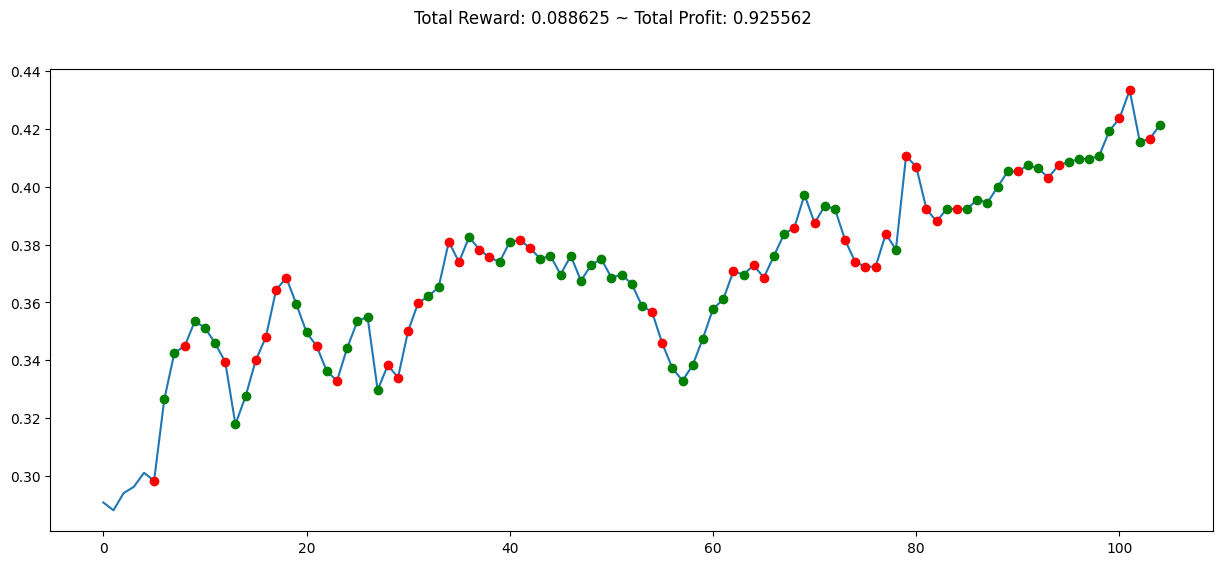

In [9]:
bot_work('MSFT')

In [3]:
date,X,y = genreate_stock_data('GME','max')

In [4]:
X['Date']=date

In [5]:
X.set_index(['Date'],inplace=True)

In [7]:
X = X.iloc[::-1]

In [12]:
env_maker = lambda: gym.make('stocks-v0', df=X, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

/home/om/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [13]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 212      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.528   |
|    explained_variance | -0.146   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.72    |
|    value_loss         | 11.3     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 275      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.688   |
|    explained_variance | -0.11    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.245   |
|    value_loss     

------------------------------------
| time/                 |          |
|    fps                | 386      |
|    iterations         | 1700     |
|    time_elapsed       | 21       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -0.658   |
|    explained_variance | 0.0284   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | -0.625   |
|    value_loss         | 1.06     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 387      |
|    iterations         | 1800     |
|    time_elapsed       | 23       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -0.541   |
|    explained_variance | 0.06     |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | -0.828   |
|    value_loss         | 4.69     |
-

-------------------------------------
| time/                 |           |
|    fps                | 400       |
|    iterations         | 3300      |
|    time_elapsed       | 41        |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -0.000925 |
|    explained_variance | -5.55     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3299      |
|    policy_loss        | -9.28e-09 |
|    value_loss         | 2.87e-08  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 400       |
|    iterations         | 3400      |
|    time_elapsed       | 42        |
|    total_timesteps    | 17000     |
| train/                |           |
|    entropy_loss       | -0.000926 |
|    explained_variance | -22.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3399      |
|    policy_loss        | 9.15e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 407       |
|    iterations         | 4900      |
|    time_elapsed       | 60        |
|    total_timesteps    | 24500     |
| train/                |           |
|    entropy_loss       | -0.000373 |
|    explained_variance | -33.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 4899      |
|    policy_loss        | 1.07e-09  |
|    value_loss         | 1.98e-09  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 407       |
|    iterations         | 5000      |
|    time_elapsed       | 61        |
|    total_timesteps    | 25000     |
| train/                |           |
|    entropy_loss       | -0.000377 |
|    explained_variance | -1.89     |
|    learning_rate      | 0.0007    |
|    n_updates          | 4999      |
|    policy_loss        | 1.51e-09  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 411       |
|    iterations         | 6500      |
|    time_elapsed       | 78        |
|    total_timesteps    | 32500     |
| train/                |           |
|    entropy_loss       | -0.000165 |
|    explained_variance | -2.94     |
|    learning_rate      | 0.0007    |
|    n_updates          | 6499      |
|    policy_loss        | -7.1e-09  |
|    value_loss         | 5.08e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 411       |
|    iterations         | 6600      |
|    time_elapsed       | 80        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -0.00016  |
|    explained_variance | -0.0712   |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | -7.75e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 413       |
|    iterations         | 8100      |
|    time_elapsed       | 97        |
|    total_timesteps    | 40500     |
| train/                |           |
|    entropy_loss       | -0.000159 |
|    explained_variance | -0.398    |
|    learning_rate      | 0.0007    |
|    n_updates          | 8099      |
|    policy_loss        | -2.25e-09 |
|    value_loss         | 3.59e-08  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 413       |
|    iterations         | 8200      |
|    time_elapsed       | 99        |
|    total_timesteps    | 41000     |
| train/                |           |
|    entropy_loss       | -0.000162 |
|    explained_variance | -0.352    |
|    learning_rate      | 0.0007    |
|    n_updates          | 8199      |
|    policy_loss        | -2.88e-09 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 411       |
|    iterations         | 9700      |
|    time_elapsed       | 117       |
|    total_timesteps    | 48500     |
| train/                |           |
|    entropy_loss       | -0.000159 |
|    explained_variance | 0.739     |
|    learning_rate      | 0.0007    |
|    n_updates          | 9699      |
|    policy_loss        | 5e-10     |
|    value_loss         | 1.59e-09  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 409       |
|    iterations         | 9800      |
|    time_elapsed       | 119       |
|    total_timesteps    | 49000     |
| train/                |           |
|    entropy_loss       | -0.000158 |
|    explained_variance | -12.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 9799      |
|    policy_loss        | 1.36e-10  |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 406       |
|    iterations         | 11300     |
|    time_elapsed       | 138       |
|    total_timesteps    | 56500     |
| train/                |           |
|    entropy_loss       | -0.00016  |
|    explained_variance | 0.0209    |
|    learning_rate      | 0.0007    |
|    n_updates          | 11299     |
|    policy_loss        | -1.43e-08 |
|    value_loss         | 1.51e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 405       |
|    iterations         | 11400     |
|    time_elapsed       | 140       |
|    total_timesteps    | 57000     |
| train/                |           |
|    entropy_loss       | -0.000158 |
|    explained_variance | -42.3     |
|    learning_rate      | 0.0007    |
|    n_updates          | 11399     |
|    policy_loss        | -5.59e-10 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 399       |
|    iterations         | 12900     |
|    time_elapsed       | 161       |
|    total_timesteps    | 64500     |
| train/                |           |
|    entropy_loss       | -0.000162 |
|    explained_variance | 0.0243    |
|    learning_rate      | 0.0007    |
|    n_updates          | 12899     |
|    policy_loss        | -2.92e-09 |
|    value_loss         | 5.89e-08  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 399       |
|    iterations         | 13000     |
|    time_elapsed       | 162       |
|    total_timesteps    | 65000     |
| train/                |           |
|    entropy_loss       | -0.000158 |
|    explained_variance | -12.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 12999     |
|    policy_loss        | 5.87e-10  |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 392      |
|    iterations         | 14500    |
|    time_elapsed       | 184      |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -6.8e-05 |
|    explained_variance | -1.85    |
|    learning_rate      | 0.0007   |
|    n_updates          | 14499    |
|    policy_loss        | 1.59e-12 |
|    value_loss         | 3.35e-11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 391      |
|    iterations         | 14600    |
|    time_elapsed       | 186      |
|    total_timesteps    | 73000    |
| train/                |          |
|    entropy_loss       | -6.8e-05 |
|    explained_variance | -0.288   |
|    learning_rate      | 0.0007   |
|    n_updates          | 14599    |
|    policy_loss        | 2.09e-11 |
|    value_loss         | 2.19e-11 |
-

------------------------------------
| time/                 |          |
|    fps                | 386      |
|    iterations         | 16100    |
|    time_elapsed       | 208      |
|    total_timesteps    | 80500    |
| train/                |          |
|    entropy_loss       | -6.8e-05 |
|    explained_variance | -645     |
|    learning_rate      | 0.0007   |
|    n_updates          | 16099    |
|    policy_loss        | 4.34e-11 |
|    value_loss         | 1.06e-10 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 386       |
|    iterations         | 16200     |
|    time_elapsed       | 209       |
|    total_timesteps    | 81000     |
| train/                |           |
|    entropy_loss       | -6.84e-05 |
|    explained_variance | 0.676     |
|    learning_rate      | 0.0007    |
|    n_updates          | 16199     |
|    policy_loss        | 7.06e-10  |
|    value_loss         | 

-------------------------------------
| time/                 |           |
|    fps                | 387       |
|    iterations         | 17700     |
|    time_elapsed       | 228       |
|    total_timesteps    | 88500     |
| train/                |           |
|    entropy_loss       | -6.79e-05 |
|    explained_variance | -0.34     |
|    learning_rate      | 0.0007    |
|    n_updates          | 17699     |
|    policy_loss        | -7.55e-11 |
|    value_loss         | 2.69e-10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 388       |
|    iterations         | 17800     |
|    time_elapsed       | 229       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -6.79e-05 |
|    explained_variance | -3.04     |
|    learning_rate      | 0.0007    |
|    n_updates          | 17799     |
|    policy_loss        | -8.26e-11 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 386       |
|    iterations         | 19300     |
|    time_elapsed       | 249       |
|    total_timesteps    | 96500     |
| train/                |           |
|    entropy_loss       | -6.79e-05 |
|    explained_variance | 0.14      |
|    learning_rate      | 0.0007    |
|    n_updates          | 19299     |
|    policy_loss        | -1.88e-11 |
|    value_loss         | 2.53e-11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 386       |
|    iterations         | 19400     |
|    time_elapsed       | 250       |
|    total_timesteps    | 97000     |
| train/                |           |
|    entropy_loss       | -6.78e-05 |
|    explained_variance | -1.33     |
|    learning_rate      | 0.0007    |
|    n_updates          | 19399     |
|    policy_loss        | -5.01e-11 |
|    value_l

In [14]:
env = gym.make('stocks-v0', df=X,frame_bound = (900,1000),window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 0.9886319965839386, 'position': 1}


NameError: name 'env' is not defined

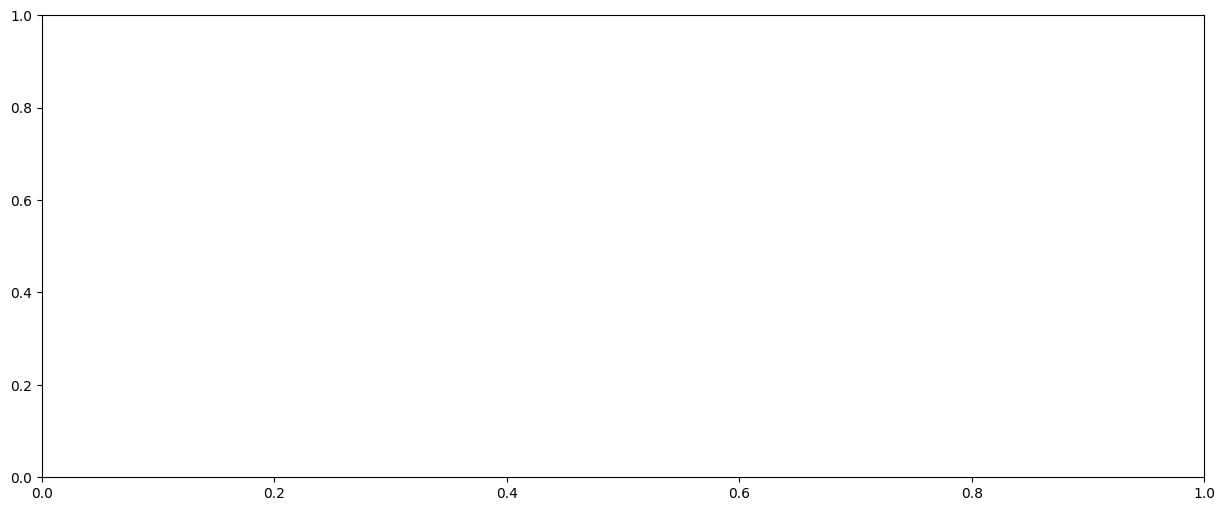

In [7]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()